## 합성곱 신경망을 사용한 이미지 분류

### 패션 MNIST 데이터 불러오기

- 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 함

- 이를 위해 넘파이 reshape() 메서드를 사용하거나 Flatten 클래스를 사용
- 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않는다

- 입력 이미지는 항상 깊이(채널) 차원이 있어야 함

- 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 채널 차원을 추가해야 함
- 넘파이 reshape() 메서드를 사용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원을 간단하게 추가할 수 있다

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

- (48000, 28, 28) 크기인 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 됨

### 합성곱 신경망 만들기

- 합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산

- Sequential 클래스의 만들고 첫 번쩨 합성곱 층인 Conv2D 추가

- 이 클래스는 다른 층 클래스와 마찬가지로 keras.layers 패키지 아래에 있음

In [3]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding = 'same', input_shape = (28, 28, 1)))

/Users/youju/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- 합성곱 층은 32개의 필터를 사용
- 커널의 크기는 (3, 3)

- 렐루 함수와 세임 패딩을 사용

- 케라스 신경망 모델의 첫 번째 층에서 입력의 차원을 지정해 주어야 함

- input_shape에 앞서 이미지를 변경했던 값으로 지정

- 풀링층 추가

- 케라스는 최대 풀링과 평균 풀링을 keras.layers 패키지 아래 MaxPooling2D와 AveragePooling2D 클래스로 제공
- Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정 가능

In [4]:
model.add(keras.layers.MaxPooling2D(2))

- 패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로제로 크기는 입력과 동일

- (2, 2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어든다
- 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 됨
- 최대 풀링을 통과한 특성 맵의 크기 > (14, 14, 32)

- 첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층을 추가

- 두 번째 합성곱-풀링 층은 첫 번째와 거의 동일
- 필터 개수를 64개로 늘린 점만 다르다

In [5]:
# 두 번째 합성곱-풀링 층
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

- 이 합성곱 층에서도 세임 패딩을 사용

- 입력의 가로세로 크기를 줄이지 않음
- 이어지는 풀링 층에서 이 크기를 절반으로 줄인다
- 64개의 필터를 사용했으므로 최종적으로 만들어지는 특성맵의 크기 > (7, 7, 64)

- 3차원 특성 맵을 일렬로 펼치지

- 마지막에 10개의 뉴런을 가진 (밀집)출력층에서 확률을 계산하기 때문
- 여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 둔다
- Flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서대로 구성

In [6]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

- 은닉층과 출력층 사이에 드롭아웃을 넣음 > 드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선 

- 은닉층은 100개의 뉴런을 사용하고 활성화 함수는 함성곱 층과 마친가지로 렐루 함수를 사용
- 패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

- 첫 번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32
- 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어남

- 반면 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어든다
- 또 두 번째 풀링 층에서 다시 절반으로 더 줄어든다
- 최종 특성 맵 크기 > (7, 7, 64)

모델 파라미터의 개수 계산

- 첫 번째 합성곱 층 > 32개의 필터 / 크기 (3, 3) / 깊이 1 / 필터마다 하나의 절편이 있음
- 3 * 3 * 1 * 32 + 32 = 320개의 파라미터

- 두 번째 합성곱 층 >  64개의 필터 / 크기 (3, 3) / 깊이 32 / 필터마다 하나의 절편
- 3 * 3 * 32 * 64 + 64 = 18.496개의 파라미터

- Flatten 클래스에서 (7, 7, 64) 크기의 특성 맵을 1차원 배열로 펼치면 > (3136,) 크기의 배열

- 이를 100개의 뉴련과 완전히 연결해야 함
- 은닉층의 모델 파라미터 개수 > 3,136 * 100 + 100 = 313,700개

- 마지막 출력층 모델 파라미터 개수 > 1,010r개

- 케라스는 summary() 메서드 외에 층의 구성을 그림으로 표현해 주는 plot_model() 함수를 keraas.utils 패키지에서 제공

In [17]:
!brew install graphviz

==> Auto-updating Homebrew...
Adjust how often this is run with `$HOMEBREW_AUTO_UPDATE_SECS` or disable with
`$HOMEBREW_NO_AUTO_UPDATE=1`. Hide these hints with `$HOMEBREW_NO_ENV_HINTS=1` (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/core/portable-ruby/blobs/sha256:1c98fa49eacc935640a6f8e10a2bf33f14cfc276804b71ddb658ea45ba99d167
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.8.arm64_big_sur.bottle.tar.gz
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
adplay: Command-line player for OPL2 music
aicommit2: Reactive CLI that generates c

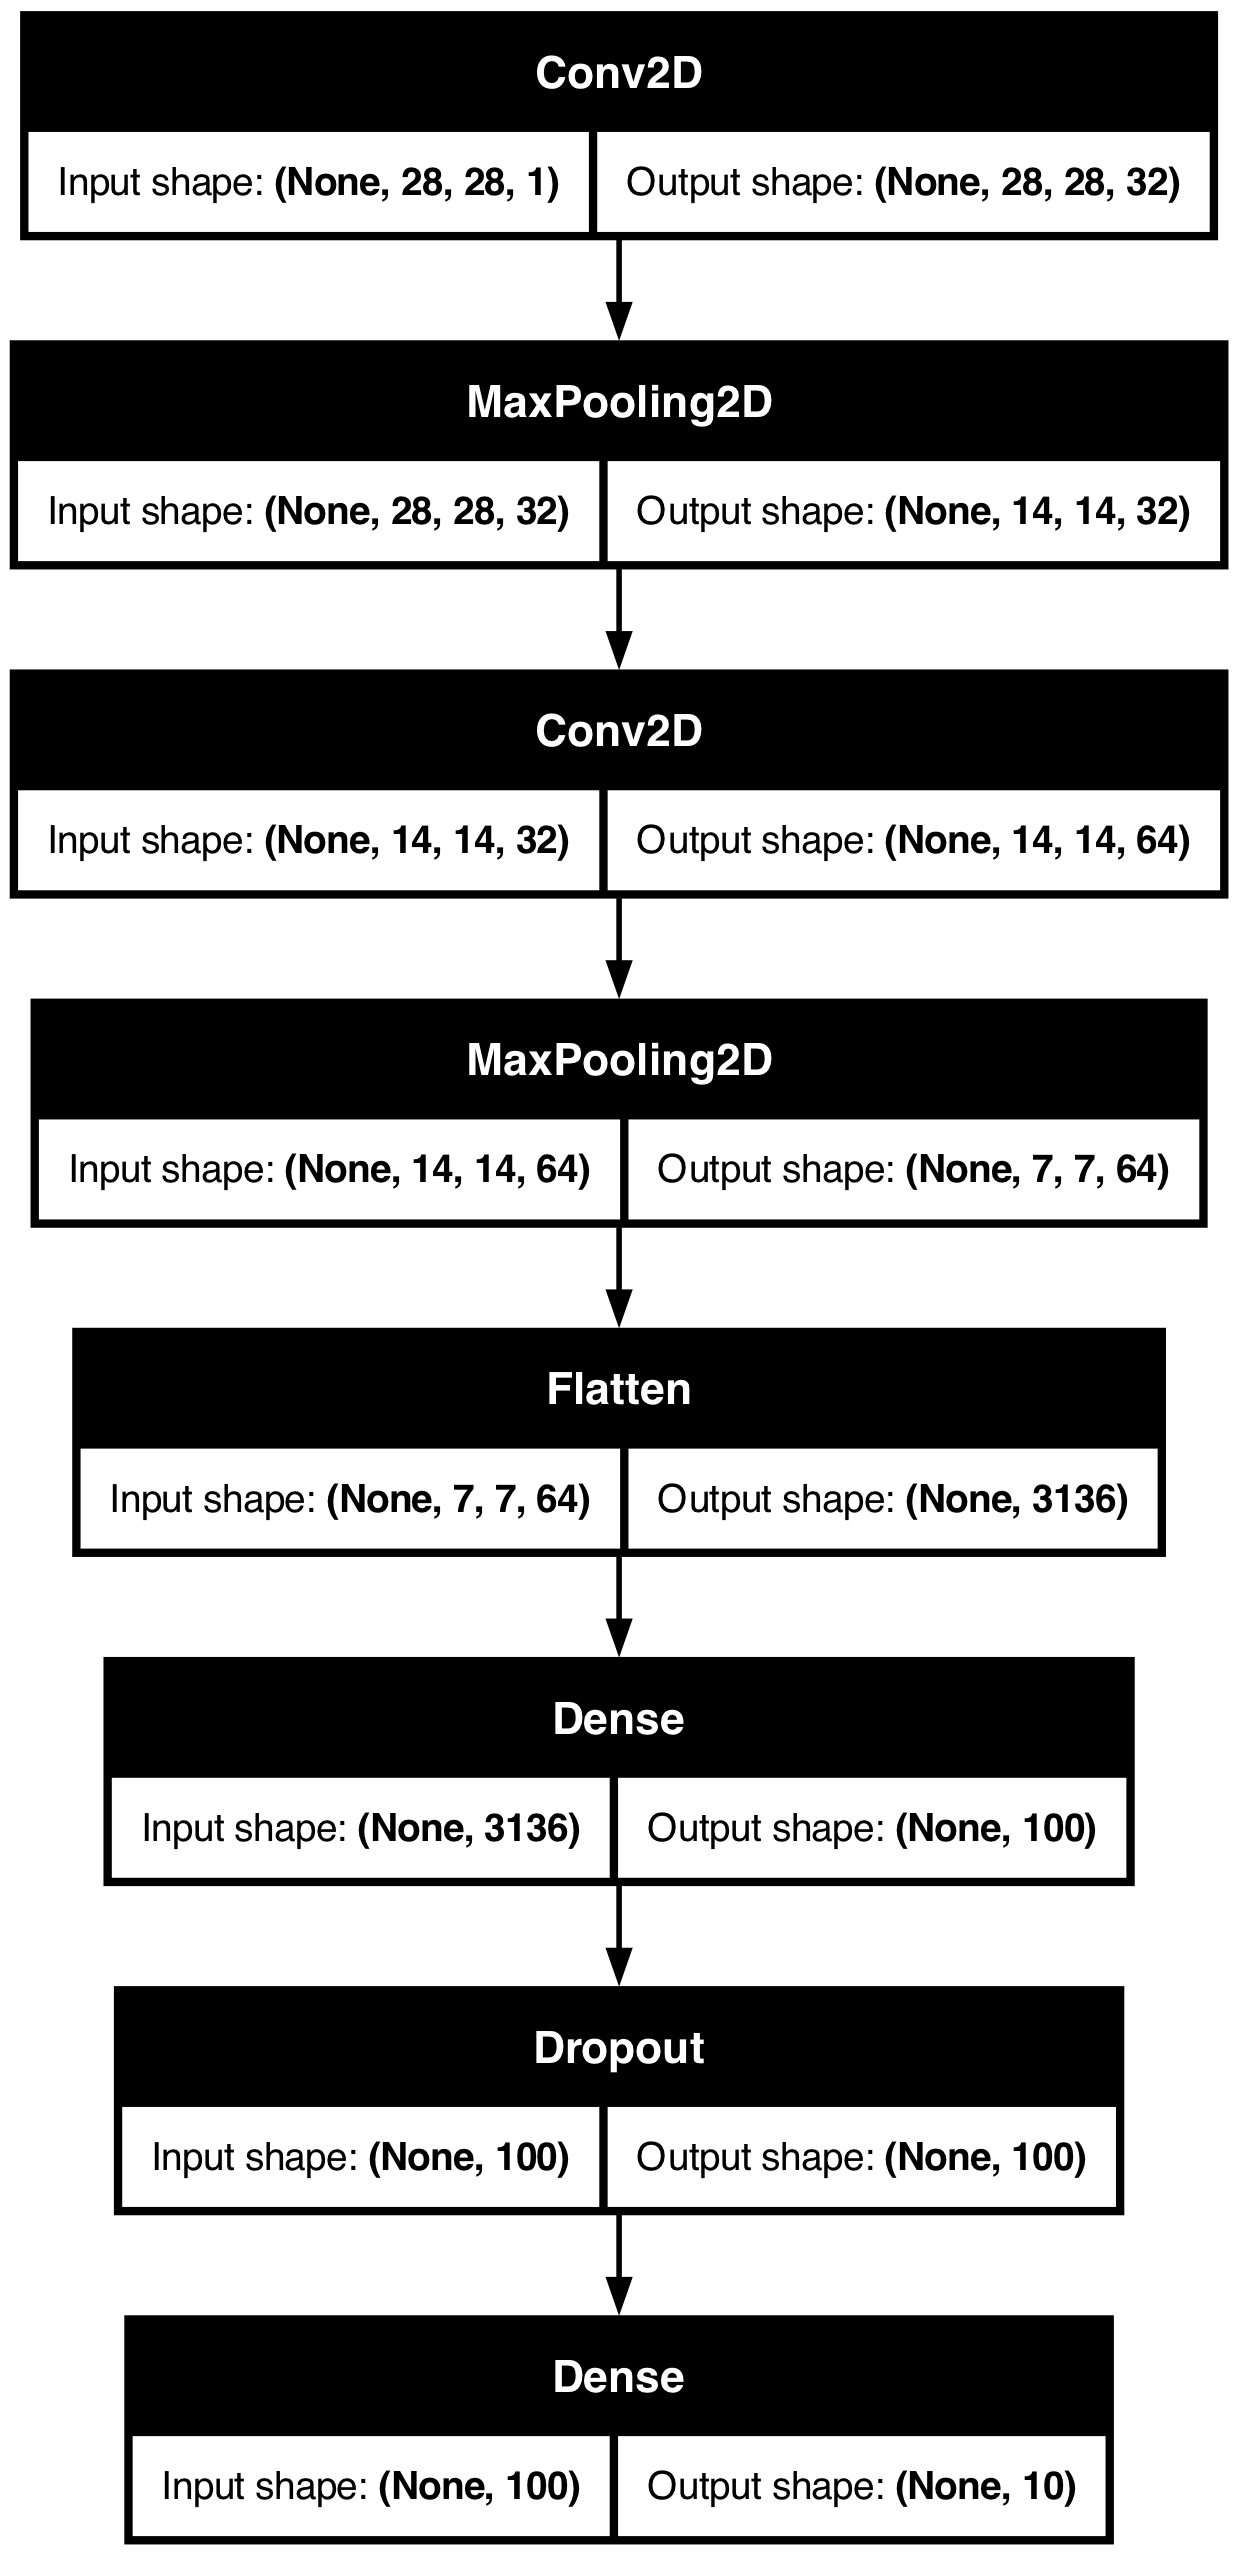

In [20]:
keras.utils.plot_model(model, show_shapes=True)

### 모델 컴파일과 훈련

- 케라스 API의 장점 > 딥려너이 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다

In [22]:
# Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data = (val_scaled, val_target),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7327 - loss: 0.7370

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8034 - loss: 0.5399 - val_accuracy: 0.8669 - val_loss: 0.3635
Epoch 2/20
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8627 - loss: 0.3795

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8696 - loss: 0.3634 - val_accuracy: 0.8893 - val_loss: 0.2872
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8864 - loss: 0.3105 - val_accuracy: 0.8919 - val_loss: 0.2881
Epoch 4/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8995 - loss: 0.2798

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9008 - loss: 0.2766 - val_accuracy: 0.9065 - val_loss: 0.2474
Epoch 5/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9083 - loss: 0.2505

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9083 - loss: 0.2512 - val_accuracy: 0.9114 - val_loss: 0.2425
Epoch 6/20
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9145 - loss: 0.2273

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9146 - loss: 0.2298 - val_accuracy: 0.9145 - val_loss: 0.2404
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9223 - loss: 0.2134

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9229 - loss: 0.2138 - val_accuracy: 0.9133 - val_loss: 0.2332
Epoch 8/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9270 - loss: 0.1971

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.9264 - loss: 0.1993 - val_accuracy: 0.9188 - val_loss: 0.2286
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9304 - loss: 0.1865 - val_accuracy: 0.9192 - val_loss: 0.2350
Epoch 10/20
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.1687

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9351 - loss: 0.1723 - val_accuracy: 0.9230 - val_loss: 0.2247
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9379 - loss: 0.1633 - val_accuracy: 0.9168 - val_loss: 0.2345
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9406 - loss: 0.1525 - val_accuracy: 0.9206 - val_loss: 0.2382


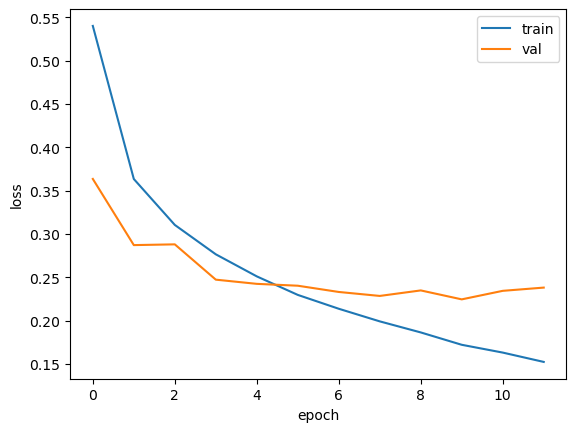

In [23]:
# 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작

- 훈련 세트에 대한 손실은 점점 더 낮아짐
- 이 그래프를 기반으로 아홉 번째 에포크를 최적으로 생각할 수 있음

- EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정 > 현재 model 객체가 최적의 모델 파라미터로 복원되어 있음

- ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없다

In [24]:
# 세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9230 - loss: 0.2247


[0.22465232014656067, 0.9229999780654907]

- 이 결과는 fit() 메서드의 출력 중 아홉 번째 에포크의 출력과 동일

- predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측

- 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정
- 맷플롯립에서는 흑백 이미지에 깊이 차원은 없다 > (28, 28, 1) 크기를 (28, 28)로 바꾸어 출력

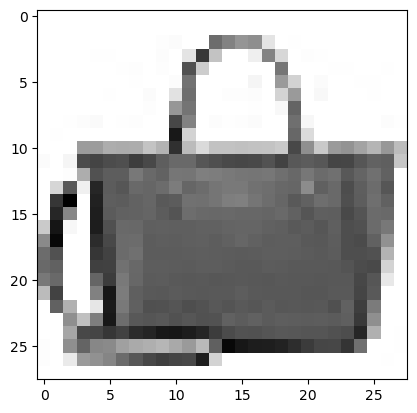

In [27]:
# 첫 번째 샘플 이미지 확인
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [28]:
# 모델은 이 이미지에 대하 어떤 예측을 만드는지 확인
# predict() 메서드는 10개의 클래스에 대한 예측 확률을 출력
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[6.6591395e-19 4.5289315e-31 8.8346633e-25 2.1921279e-25 2.6411502e-22
  7.5204900e-23 2.7470129e-21 9.9443079e-31 1.0000000e+00 7.2947854e-30]]


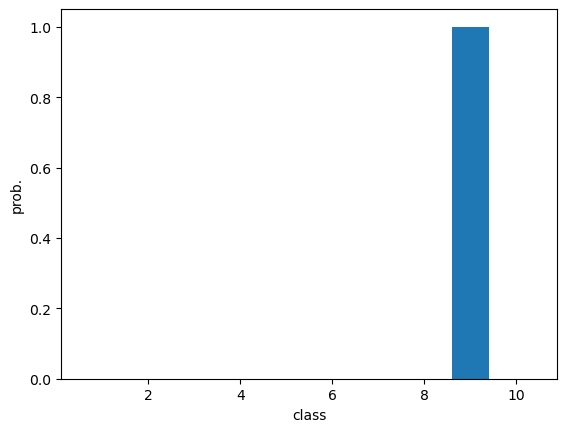

In [29]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [30]:
# 파이썬에서 레이블을 다루기 위해 리스트로 저장
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈',
           '가방', '앵클 부츠']

In [31]:
# preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용
import numpy as np
print(classes[np.argmax(preds)])

가방


- 맨 처음에 떼어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능 가늠

- 이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능 측정

In [32]:
# 픽셀값 범위 0~1 / 이미지 크기 (28, 28, 1)로 바꾸기
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [33]:
# 테스트 세트에 대한 성능 측정
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9158 - loss: 0.2464


[0.2464262694120407, 0.9157999753952026]